In [8]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal

class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean((self.v_model(b_states) - b_returns.detach()) ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

class PPO_Advantage(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, next_states, rewards, dones):
        
        states, actions, next_states, rewards, dones = map(np.array, [states, actions, next_states, rewards, dones])
        states, actions, next_states, rewards = map(torch.FloatTensor, [states, actions, next_states, rewards])
        rewards = rewards.reshape(-1, 1)
        
        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]
            
        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])
        
        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):

            # print(next_states.shape, states.shape, actions.shape, rewards.shape)

            idxs = np.random.permutation(next_states.shape[0])
            for i in range(0, next_states.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_rewards = rewards[b_idxs]
                b_next_states = next_states[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_rewards + self.gamma * self.v_model(b_next_states) - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean((self.v_model(b_states) - b_returns.detach()) ** 2)
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

C:\Users\timo2\AppData\Roaming\Python\Python39\site-packages\gym\utils\env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


0 -1095.4691398773612
1 -902.8999068646094
2 -1085.9632832773182
3 -776.917509669388
4 -130.0279051840464
5 -255.90857951435427
6 -380.1856688844944
7 -1048.8352769331148
8 -241.43236447364418
9 -130.56387797209285
10 -130.85812255348236
11 -127.1596480877083
12 -2.2128145231910104
13 -244.3921656668647
14 -128.2415369946134
15 -257.2634979597316
16 -246.57143309604987
17 -256.8718341203695
18 -130.31574728906062
19 -135.7134618495631
20 -443.3352166354474
21 -129.87609775634738
22 -381.9898266241235
23 -267.7051176698834
24 -128.97945349836795
25 -127.63410207446339
26 -1.0703286371137573
27 -127.25356438213066
28 -249.71635794722104
29 -1.1069014318132417
30 -128.49956661260507
31 -128.6006232868213
32 -250.34929627118527
33 -374.51423620834834
34 -504.89410552517677
35 -2.8971484422210203
36 -131.06002669650147
37 -369.7254225781699
38 -262.7895336946073
39 -128.2669158487042
40 -248.25477590031417
41 -340.3092871746442
42 -130.87957254841552
43 -128.75954738222316
44 -128.847427973

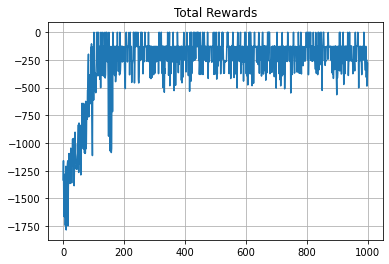

In [5]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO_Advantage(state_dim, action_dim)

episode_n = 50
trajectory_n = 20

total_rewards_advantage = []

for episode in range(episode_n):

    next_states, states, actions, rewards, dones = [], [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)
            next_states.append(state)

            total_reward += reward

        total_rewards_advantage.append(total_reward)

    agent.fit(states, actions, next_states, rewards, dones)

    print(episode, total_reward)

plt.plot(total_rewards_advantage)
plt.title('Total Rewards')
plt.grid()
plt.show()

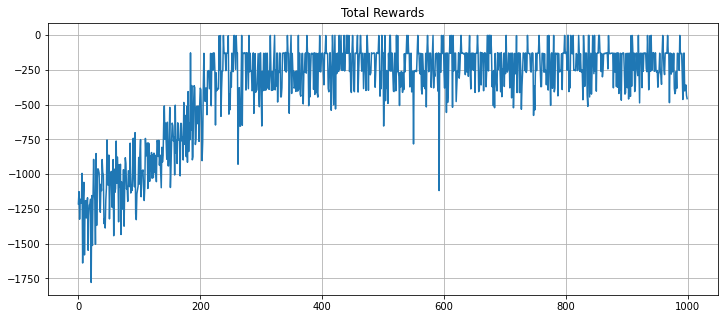

In [9]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim)

episode_n = 50
trajectory_n = 20

total_rewards = []

for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)

    agent.fit(states, actions, rewards, dones)
    print(episode, total_reward)
    
plt.plot(total_rewards)
plt.title('Total Rewards')
plt.grid()
plt.show()

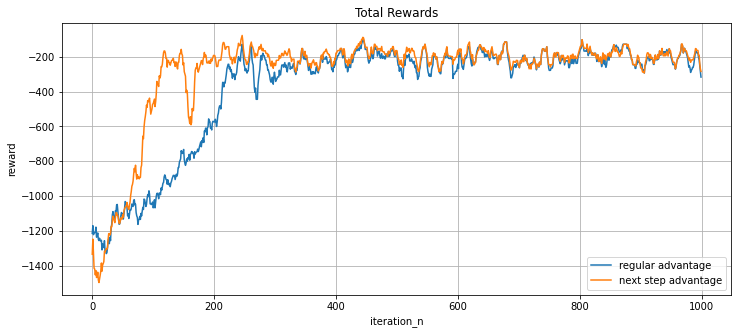

In [10]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(pd.Series(total_rewards).rolling(10, 1).mean(), label = 'regular advantage')
plt.plot(pd.Series(total_rewards_advantage).rolling(10, 1).mean(), label = 'next step advantage')
plt.xlabel("iteration_n")
plt.ylabel("reward")
plt.title('Total Rewards')
plt.legend(loc = 'best')
plt.grid()
plt.show()